In [1]:
# Source - https://github.com/sre-customer-training/lab1-estadistica-descriptiva

__author__ = "Andres M. Correa"
__copyright__ = "BSD 3-Clause License"
__credits__ = []
__license__ = "BSD"
__version__ = "3"
__maintainer__ = "Andres M. Correa"
__email__ = "amcorrea0@gmail.com"
__status__ = "Labs for SRE"

# Nivel 3: Gestión de Outliers (Borrar vs. Analizar)

**Escenario:** Seguimos con las ventas, pero el sistema de registro falló un día (registró -1000 ventas) y otro día hubo un evento masivo (Black Friday) que disparó las ventas. Objetivo SRE: Aprender a diferenciar un Error de Datos (que se borra) de una Anomalía de Negocio (que se analiza).

## Generador de Datos con Anomalías

Guarda como generador_anomalias.py.

```
import pandas as pd
import numpy as np

def generar_datos_sucios():
    # Usamos base aleatoria simple
    data = np.random.normal(100, 10, 200) # 200 datos normales
    df = pd.DataFrame(data, columns=['Latencia_ms'])
    
    # --- INYECTAR ANOMALÍAS ---
    
    # CASO 1: Error Técnico (Sensor roto)
    # Valores negativos o ceros imposibles en latencia
    df.loc[10, 'Latencia_ms'] = -50 
    df.loc[20, 'Latencia_ms'] = -999
    
    # CASO 2: Incidente Real (Sobrecarga / DDoS)
    # Valores positivos extremadamente altos
    df.loc[50, 'Latencia_ms'] = 500  # 5x lo normal
    df.loc[51, 'Latencia_ms'] = 520
    df.loc[52, 'Latencia_ms'] = 480
    
    df.to_csv('../datos/datos_latencia_sucia.csv', index=False)
    print("✅ Archivo '../datos/datos_latencia_sucia.csv' generado con errores y crisis.")

if __name__ == "__main__":
    generar_datos_sucios()
```

### Notebook Nivel 3: El Dilema del Outlier

**Paso 1: Identificación Visual (Boxplot)**

![Boxplot](../images/boxplot.png)

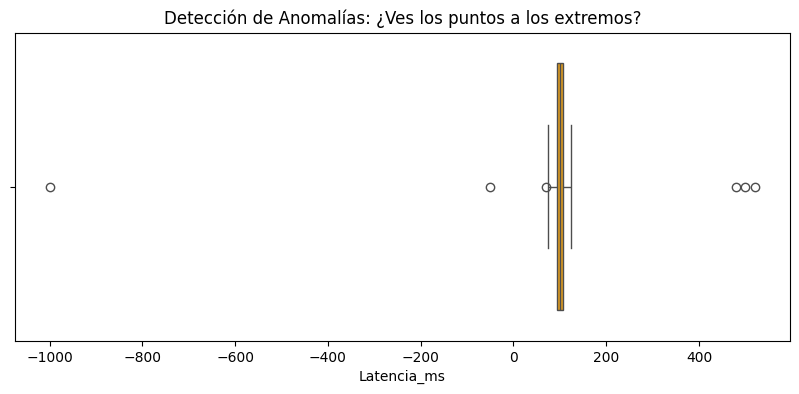

Observación: Tenemos puntos a la izquierda (negativos) y muy a la derecha (altos).


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('../datos/datos_latencia_sucia.csv')

# Visualizar el problema
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['Latencia_ms'], color='orange')
plt.title('Detección de Anomalías: ¿Ves los puntos a los extremos?')
plt.show()

print("Observación: Tenemos puntos a la izquierda (negativos) y muy a la derecha (altos).")

**Paso 2: CASO A - Limpieza (Error Técnico)**

*Lógica:* La latencia no puede ser negativa. Esto es basura. Si calculamos el promedio con esto, estará mal. Acción: Eliminar y Recalcular.

In [6]:
# Estadísticas ANTES de limpiar
print(f"Promedio SUCIO: {df['Latencia_ms'].mean():.2f} ms")

# Identificar basura lógica (Latencia < 0)
errores_tecnicos = df[df['Latencia_ms'] <= 0]
print(f"Detectados {len(errores_tecnicos)} registros erróneos (negativos).")

# Limpiar (Filtrar)
df_clean_tech = df[df['Latencia_ms'] > 0].copy()

# Estadísticas DESPUÉS de limpiar basura
print(f"Promedio LIMPIO (Técnico): {df_clean_tech['Latencia_ms'].mean():.2f} ms")
print("✅ Hemos eliminado el ruido del sensor. Ahora los datos son 'físicamente' posibles.")

Promedio SUCIO: 99.21 ms
Detectados 2 registros erróneos (negativos).
Promedio LIMPIO (Técnico): 105.51 ms
✅ Hemos eliminado el ruido del sensor. Ahora los datos son 'físicamente' posibles.


**Paso 3: CASO B - Análisis de Incidente (Outlier Real)**

*Lógica:* Ahora vemos valores de 500ms. ¿Son errores? No. Son positivos. ¿Son normales? No. Son incidentes. Acción: No borrarlos. Aislar y Estudiar.

Límite de normalidad calculado: 126.28 ms

--- REPORTE SRE ---
Tráfico Normal: 195 peticiones. Promedio: 99.44 ms
🚨 INCIDENTES: 3 peticiones detectadas.
Valores de crisis: [500. 520. 480.]


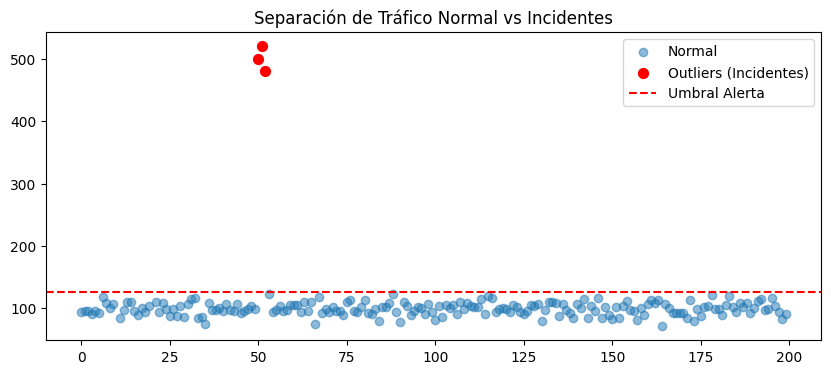

In [7]:
# Usamos el Rango Intercuartil (IQR) para detectar lo que se sale de lo normal
Q1 = df_clean_tech['Latencia_ms'].quantile(0.25)
Q3 = df_clean_tech['Latencia_ms'].quantile(0.75)
IQR = Q3 - Q1

# Definimos umbral de "Anomalía" (Bigote superior del boxplot)
umbral_superior = Q3 + 1.5 * IQR

print(f"Límite de normalidad calculado: {umbral_superior:.2f} ms")

# Separamos los mundos
df_normal = df_clean_tech[df_clean_tech['Latencia_ms'] <= umbral_superior]
df_incidente = df_clean_tech[df_clean_tech['Latencia_ms'] > umbral_superior]

print("\n--- REPORTE SRE ---")
print(f"Tráfico Normal: {len(df_normal)} peticiones. Promedio: {df_normal['Latencia_ms'].mean():.2f} ms")
print(f"🚨 INCIDENTES: {len(df_incidente)} peticiones detectadas.")
print(f"Valores de crisis: {df_incidente['Latencia_ms'].values}")

# Gráfico final de separación
plt.figure(figsize=(10, 4))
plt.scatter(df_normal.index, df_normal['Latencia_ms'], label='Normal', alpha=0.5)
plt.scatter(df_incidente.index, df_incidente['Latencia_ms'], color='red', label='Outliers (Incidentes)', s=50)
plt.axhline(umbral_superior, color='red', linestyle='--', label='Umbral Alerta')
plt.title('Separación de Tráfico Normal vs Incidentes')
plt.legend()
plt.show()

### Conclusión:

Al finalizar el Nivel 3, habrás aprendido que:

**Nivel 1:** La mediana es mejor amiga que el promedio.

**Nivel 2:** Los datos se mueven (tendencias) y respiran (desviación estándar). Usamos Rolling Averages para ver claro.

**Nivel 3:** 
* Si el dato es imposible (latencia negativa) -> DELETE (Data Hygiene).

* Si el dato es posible pero extremo (latencia alta) -> KEEP & ANALYZE (Incident Management).